<h2><center>Introduction </center></h2>

I would like to continue the previous notebook **Weight_evolution_in_shallow_NN**, where I briefly motivated the  process of optimization in a Neural Network (NN) from the perspective of mass shuffling or, if you think in terms of particles or has some experience with kinetic theory, of kinetic equilibration. 

Initially I found it a very particular point of view about the problem, to later discover (after some quick research) that other people have thought about that too. Here however we are not going to mention gradient flows or anything like that. Instead, we shall go cheap (indeed, veeery cheap!!), just to get a felling of how to sketch a design of different approaches to train a NN.

>__Remark:__ If you are interested in reading other approaches to training, a bit closer to the gradient flows, you should read
https://papers.nips.cc/paper/8101-stein-variational-gradient-descent-as-moment-matching
There is a clear connection between the ideas here and those in kinetic theory, gradient flow of measures and so, but that is beyond the scope of this notebook.



As before, first we import some libraries

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set(style="darkgrid")

In the beginning part of the notebook coincide with the previous one (because we need to artificially create data). In part 2 things start to change, and most of the discussion starts there.

<h2><center> 1 - Prediction boundaries:  linear case study </center></h2>

The problem lies in the category of supervised learning: we have a sample of elements of type $(X_i,Y_i)$, for $1 \leq i \leq N$, all independent and identically distributed, and we would like to train a predictor.


Let's start by generating a sample $X_i$, which will be normally distributed.

In [2]:
N = 1000
X = 10*np.random.randn(2,N)

With regards to the label Y, we are going to use the following classifier: 

\begin{align}
Y=1, \quad \mbox{whenever } \qquad  x_1 \geq 0, \quad   Y=0 \qquad \text{ otherwise}.
\end{align}


In [3]:
Y = np.array((X[0,:]+2*X[1,:]>=10),np.int32)

If we plot we see this:

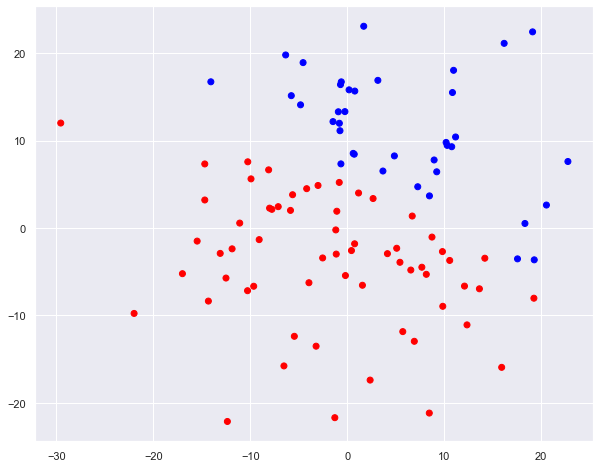

In [4]:
colors =['red','blue']
vec_color = [colors[i] for i in Y[:]]
plt.figure(figsize=(10,8))
plt.scatter(X[0,:100],X[1,:100],color=vec_color[:100])

<h3>1.1 -  Augmenting the dimension </h3>

Let's make the dimension of this problem a bit higher. The ith element in our sample, which so far is in $\mathbb{R}^2$, has coordinates X[i,:]. Initially, we shall consider this as a set of points lying on an embedded, 2 dimensional, manifold in a higher dimensional space.


In [5]:
additional_dimension = 13
Additional_dimension_coordinates = np.zeros([additional_dimension,N])

In [6]:
X = np.concatenate((X,Additional_dimension_coordinates),axis=0)

Just to check the dimensions, X should now have dimension $(2+13)\times N$

In [7]:
X.shape

(15, 1000)

which is indeed the case. 

Now in these "extra dimensions" we would like to add some small noise. The idea is that, as  we collect data, these  entries play the role of irrelevant features (but we didn't know that at the time of data gathering! How could we?!).

In [8]:
X[2:,:] = .01*np.random.randn(additional_dimension,N)

For instance, if we plot the first 3 dimensions, we will see that most of the points are clustered around the plane $(x_1,x_2)$ defined by the first two coordinates

<Figure size 432x288 with 0 Axes>

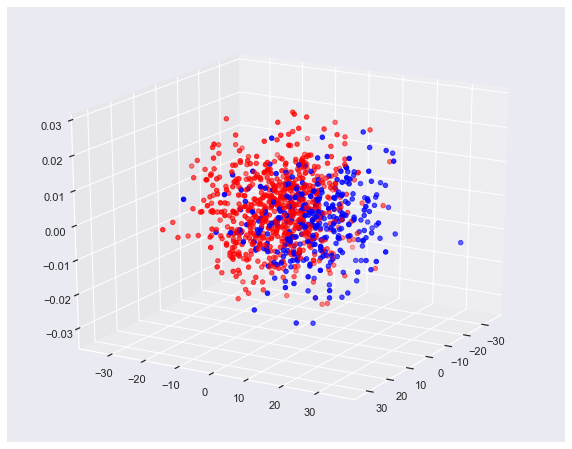

In [9]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X[0,:1000],X[1,:1000],X[2,:1000],color=vec_color[:1000]);
ax.view_init(20, 30)

Note the difference in magnitude of all the x,y axis to the z axis. We can make this difference visualy more pronounced if we plot everythin with the same scale:

<Figure size 432x288 with 0 Axes>

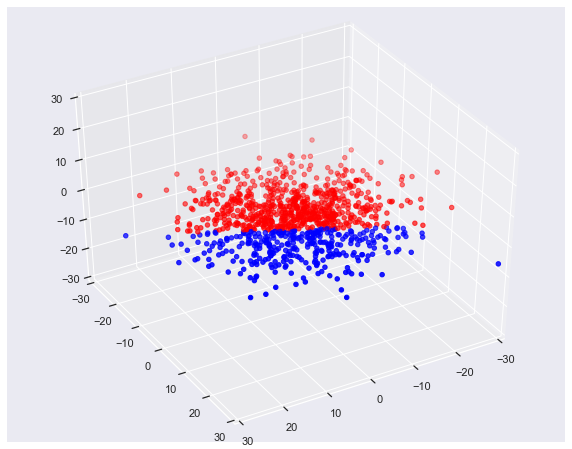

In [10]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[0,:1000],X[1,:1000],X[2,:1000],color=vec_color[:1000]);
ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(-30, 30)

ax.view_init(40, 60)  # This sets the angle by which we rotate the axis

You can see that the training set is separated (although not that much, because there is no gap).

<h3> 1.2 - Constructing a training and a test set  </h3>

We would like to set part of the sample apart so that it can be used for testing the model. However, we would like to have a stratified sample: both training, test, and CV set should have more or less the same proportion of $Y=1$ and $Y=0$

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split_sample= StratifiedShuffleSplit(n_splits=1, test_size=.2)

for train_index, test_index in split_sample.split(np.transpose(X),np.transpose(Y)):
    X_train,Y_train = X[:,train_index],np.reshape(Y[train_index],(1,-1))
    X_test,Y_test = X[:,test_index],np.reshape(Y[test_index],(1,-1))  

>__Just a quick remark on the above computation:__ note that we are using a strange "transpose" on X and Y to do the "split_sample.split(,). That's the case because the arguments for this function are of type 
       X : array-like, shape (n_samples, n_features)
       (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)
That's not a big deal though: as the output is an array of integers, we can use i in the columns. That's why we don't use the transpose when we assign X_train, Y_train and so.

Let's count the proportion in each group:


In [12]:
print("Proportion of elements in whole sample is: ",str(np.sum(Y)/len(Y))+"\n")
print("Proportion of elements in train set is: ", str(np.sum(Y_train)/Y_train.shape[1])+"\n")
print("Proportion of elements in test set is: ", str(np.sum(Y_test)/Y_test.shape[1]))

Proportion of elements in whole sample is:  0.33

Proportion of elements in train set is:  0.33

Proportion of elements in test set is:  0.33


We are in good shape: we are ready to go and discuss the predictive model and its training.

<h2><center>2 - Training a simple logit regression </h2></center>

We shall make use of __import tensorflow_probability as tfp__ . 

The main idea here is trying something different, and that will involve flipping coins, randomizing the heuristics. In fact, Gradient Descent is just one type of heuristics for weight calibration; as I mentioned before, there are many other. 


In [13]:
import tensorflow_probability as tfp


In the process of training a log regression I would like to see how the mass gets reshuffled in the weigh matrix. The model goes like this: denote the sigmoid function by $\sigma(\cdot)$, which we write as

$$ \sigma(z) = \frac{1}{1 + \exp(z)}, \quad z\in \mathbb{R}.$$

In our case we are going to use the following: we are interested in finding a vector $W \in \mathbb{R}^{k}$ and a quantity $b\in \mathbb{R}$ that will be used in our predictor. To be more precise, we will have

$$ \hat{Y} = \left\{\begin{array}{ccc}
1, &if &\quad \quad \sigma(W\cdot X + b) \geq \eta\\
0 , &if &\quad \quad \sigma(W\cdot X + b) < \eta
\end{array}\right..$$

In fact, we know that $W = e_1 = (1, 0, 0, \ldots, 0)$ is the predictor that we are looking for. So, as we train our model we would like to see the entries $W_i$ (weights) in the matrix W to decay to 0 for $i\geq 2$ and converge to a positive number for $W_1$.

It is not hard to do this training using scikit-learn, but this is not what we want: we want to go old school on this, so we are going to design the method by ourselves. 

>__Remark:__ in the code you will see no $\eta$. That's because the tensorflow.round automatically sets $\eta =.5$. This function was used as a matter of convenience, and it is not hard to change it to the general case, that includes $\eta$ as parameter.


The main difference here is that we will only allow the nodes in $W^{(1)}$ to assume three values: $\eta$, $0$, or  $ -\eta$, where $\eta$ is a positive quantity.

__With what purpose?__

Well... let's think: $\eta$ is the intensity of belief of that note on that parameter in order to do a prediction. One can say that it measures the polarization of the model. In that sense one should keep in mind the behavior of the quantity ($H(\cdot)$ is a Heaviside function)


$$\sigma(\eta x + b) = \left\{\begin{array}{ccc}
H(x),&  for &\eta \to +\infty\\
\sigma(b),&  for &\eta \to 0
\end{array}\right.$$

In other words: the model is very reactive in the first case, while very indiferent (apathetic) in the second.



<h3>2.1 - Auxiliary functions </h3>

First we design a weigh initializer; afterwards we design a forward propagation.


Note that we will keep k as a variable, for we want to study the effect of dimensionality in the model. So, to begin with we get a numpy vector with the number of nodes in each layer. This is going to be the vector "nodes_per_layer". Note that the number of nodes in the ith column will be given by "nodes_per_layer[i]"

In [14]:
k = 2 + additional_dimension
nodes_per_layer = np.array([k,1],ndmin=1)

Now we can initialize the weights that will connect the layers. Note that, from the perspective we want to study here, the "mass" will flow throught "pipes" that have weights given by the matrices W


One thing to note in the next code is that part of it can be reused in larger NNs (which is something that we will do later). For instance, in the case of logits one can avoid the use of dictionaries. We left things a bit longer in a somewhat unecessary fashion, but with the intention of making th ecode more portable for future applications.

In [15]:
def weight_initializer(nodes_per_layer,eta):
    '''
    Initialize the matrix W with dimensions 1xk and the 1x1 parameter b
    '''
    L = len(nodes_per_layer)   
    parameters={}    
    
    p_w = [1./3,1./3,1./3]
    flip_w = tfp.distributions.Categorical(probs=p_w)
    p_b = [1./2,1./2]
    flip_b = tfp.distributions.Categorical(probs=p_b)
    counts_w = np.array([-eta,0,eta],dtype=np.float32)
    counts_b = np.array([-1,1],dtype=np.float32)
   
    with tf.Session() as sess:
        
        for i in range(1,L):
            aux = np.reshape(counts_w[sess.run(flip_w.sample(nodes_per_layer[i-1]))],(1,-1))
            W = tf.constant(aux, shape=[nodes_per_layer[i],nodes_per_layer[i-1]],dtype=tf.float32)
            b = tf.constant([0],dtype=tf.float32,shape= [nodes_per_layer[i],1])#tf.get_variable("b",dtype=tf.int32,initializer=tf.constant([0]))
            
    return (W,b)

> __Remark:__ In fact, all of the previous cell could have been implemented easily using numpy. It is good to know other libraries though.

For instance, if we set eta =5 , we get this output

In [16]:
eta = 5
tf.reset_default_graph()
parameters = weight_initializer(nodes_per_layer,eta)

with tf.Session() as sess:
    tf.global_variables_initializer
    print(sess.run(parameters))

(array([[ 5.,  0.,  0.,  5., -5.,  0.,  5.,  0.,  0.,  0.,  5., -5., -5.,
         5.,  5.]], dtype=float32), array([[0.]], dtype=float32))


The next thing that we need to do is a propagator. For tris we will receive a tuple with strings, whose entries describe the activation function in that layer. What we have is the following:

$$Z[i] = W[i]\cdot A[i-1] + b[i]$$

where $A[i-1]$ denotes the output of the previous layer. Note that the dimensions math: A[i-1] has dimension $n_{i-1}\times 1$, while W[i] has dimensions $n_{i}\times n_{i-1}$, hence Z[i] is a vector of dimensions $n_{i}\times 1$.

Before we write the propagation function, we are going to set the activation function vector:

In [17]:
type_activation = ['sigmoid']

Let's implement the function as a single layer model (it can be generalized to deeper NN, but the implementation gets a bit more technical; we won't worry about that for now)

In [18]:
def propagator(W,b,type_activation,X_tensor):
    L = len(type_activation)
    
    A = X_tensor
    for i in range(L):
        if type_activation[i]=='relu':
            Z = tf.add(tf.matmul(W,A),tf.cast(b,tf.float32))
            if i !=L-1:
                Z = tf.nn.relu(Z)
        elif type_activation[i]=='sigmoid':
            Z = tf.add(tf.matmul(W,A),tf.cast(b,tf.float32))
            if i !=L-1:
                Z = tf.nn.sigmoid(Z)
    return Z

It will be useful to use to consider the weight as parameters: the graph will always be the same, but we shall modify the weights as we go.

For example, we shall use it as follows:

In [19]:
tf.reset_default_graph()

# Create some placeholders
X_tensor = tf.placeholder(name="X_tensor", shape=[nodes_per_layer[0],None],dtype=tf.float32)
W=tf.placeholder(name="W",shape =[nodes_per_layer[1],nodes_per_layer[0]],dtype=tf.float32)
b= tf.placeholder(name="b",shape =[nodes_per_layer[1],1],dtype=tf.float32)

with tf. Session() as sess:
    init = tf.global_variables_initializer()
    Z_tensor = propagator(W,b,type_activation,X_tensor)
    sess.run(init)
    W_val,b_val = sess.run(weight_initializer(nodes_per_layer,eta))
    print(sess.run(Z_tensor, feed_dict={X_tensor:X_train,W: W_val, b:b_val})[0,0])

16.93277


Did you note that we don't get an integer number?  That's because the last layer was not 'hit' by an activation function (yet). This is due to the structure of the cross entropy function as implemented in tensorflow. In this link they say that: [https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits]

Well... so let's compute the cost/loss function:

In [20]:
def cost_function(Z,Y):
    cost= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z,labels=Y))
   
    return cost

Which will give, for example, something like this

In [21]:
tf.reset_default_graph()

X_tensor = tf.placeholder(name="X_tensor", shape=[nodes_per_layer[0],None],dtype=tf.float32)
Y_tensor = tf.placeholder(name="Y_tensor", shape=[nodes_per_layer[1],None],dtype=tf.float32)

W=tf.placeholder(name="W",shape =[nodes_per_layer[1],nodes_per_layer[0]],dtype=tf.float32)
b= tf.placeholder(name="b",shape =[nodes_per_layer[1],1],dtype=tf.float32)

with tf.Session() as sess:
    init = tf.global_variables_initializer()    
    Z_tensor = propagator(W,b,type_activation,X_tensor)
    
    sess.run(init)
    W_val,b_val = sess.run(weight_initializer(nodes_per_layer,eta))
    
    print(sess.run(cost_function(Z_tensor,Y_tensor),\
                   feed_dict={X_tensor:X_train,W: W_val, b:b_val, Y_tensor:Y_train} )
         )

W0912 12:22:49.095024 140735522845568 deprecation.py:323] From /miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3.5357707


Great! So we are ready to discuss the training heuristics.

<h2><center>Cost minimization  heuristics </center></h2>


At this point we have another concern: how are we going to minimize the cost function? Our strategy will be the following: b will be as follow:
   $$b \leftarrow b\pm 1$$
 with probability $\frac{1}{2}$
 
 W will have a different rule: we will flip k coins (ok, ok: three-sided coins, but let's allow some abstraction here, please) and change the weight. However we will have an acceptance rule:
 
 >__Acceptance rate:__ observe random variables $\tilde{W}$ and $\tilde{b}$ as described above.
 If $$Cost(\tilde{W},\tilde{b}) < Cost(W,b),$$ do $W \leftarrow\tilde{W}$, $b \leftarrow\tilde{b}$; otherwise W and b remain the same.

>__Remark:__ in fact, we will test different combinations of $\tilde{W}$, $\tilde{b}$, $W$, and $b$. Take a look at the function "full_model"

 This is definitely not the best model, but it is a decent one: we are exploring the parameter space, and we don't seem to be biased by any particular direction. This part should be in high constrast to the previous, continuous case: What makes the problem a bit more complicated here is that W lives in a state space of size $3^{k}$, while b is discrete. Even though this is (intuitively) smaller than $(W,b )\in \mathbb{R}^k\times\mathbb{R}$, our heuristics in the latter case is way better than in the discrete case; this is also the case in the fields of continuous optimization and discrete optimization.
 
 > __Question:__ again, why are you doing this? There are many reasons. First, Gradient descent is not the only way to optimize a model. Currently,there is lot of research/discussion about other training methods (Steing Gradient descent, for instance), and a lot of connection between these type of models to studies in kinetic theory and "asymptotic equilibration". Second reason: because it is easy to press a button and use any scikit-learn model without having any mathematical ability (I had met AI people like that a few times in my career). 

In [22]:
def next_step(W_old,b_old,p_w,p_b,eta, type_activation):
    '''
    p_w are the acceptance probability of W and b
    '''
    flip_w = tfp.distributions.Categorical(probs=p_w)
    flip_b = tfp.distributions.Categorical(probs=p_b)
    counts_w = np.array([-eta,0,eta],dtype=np.float32)
    init = tf.global_variables_initializer()
    
    ## Generate new radnom variable
    with tf.Session() as sess:

        W_new = W_old +np.reshape(counts_w[sess.run(flip_w.sample(nodes_per_layer[0]))],(1,-1))

        b_new= b_old +2*(2*sess.run(flip_b.sample(1)) -1)
        
        parameters_new = W_new,b_new
        
        return parameters_new

In [23]:
tf.reset_default_graph()
p_w = [1./3,1./3,1./3]
p_b = [1./2,1./2]

# flip the three sided coin
flip_b = tfp.distributions.Categorical(probs=p_b)

# Set up placeholders
X_tensor= tf.placeholder(dtype=tf.float32,shape=[k,None]) 
Y_tensor= tf.placeholder(dtype=tf.float32,shape=[1,None])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    W_old, b_old = sess.run(weight_initializer(nodes_per_layer,eta))
    print(next_step(W_old,b_old,p_w,p_b,eta,type_activation))

(array([[  5.,  -5.,   0.,   0.,   0.,  -5.,   5.,   0.,  10.,   5.,  -5.,
          0., -10.,  -5.,   5.]], dtype=float32), array([[-2.]]))


Let's test:

In [24]:
tf.reset_default_graph()

X_tensor= tf.placeholder(dtype=tf.float32,shape=[k,None]) 
Y_tensor= tf.placeholder(dtype=tf.float32,shape=[1,None])

W=tf.placeholder(name="W",shape =[nodes_per_layer[1],nodes_per_layer[0]],dtype=tf.float32)
b= tf.placeholder(name="b",shape =[nodes_per_layer[1],1],dtype=tf.float32)

# Now we define the weights
parameters = weight_initializer(nodes_per_layer,eta)

Z = propagator(W,b,type_activation,X_tensor)
cost = cost_function(Z,Y_tensor)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    W_old, b_old = sess.run(weight_initializer(nodes_per_layer,eta))
    print(sess.run(cost_function(Z,Y_tensor),feed_dict={X_tensor:X_train,Y_tensor:Y_train,W:W_old,b:b_old}))
    

51.959717


Now we run the model. Let's first set some parameters for the search:

In [25]:
optimization_parameters={
    'epochs':200,
    'printing':True
}

ntwk_settings={
    'number_nodes':nodes_per_layer,
    'activation_type':type_activation
}

And now we draw the model and run the data through it

In [26]:
def full_model(optimization_parameters,eta,ntwk_settings,X_train,Y_train,X_test,Y_test):
    
    ## Unpacking
    nodes_per_layer = ntwk_settings['number_nodes']  ## Recall, this is a dimension k x 1 matrix
    type_activation = ntwk_settings['activation_type']
    #learning_rate = optimization_parameters['learning_rate']
    epochs = optimization_parameters['epochs']
    printing = optimization_parameters['printing']
    
    tf.reset_default_graph()
    # first we create placeholders: they are the ones that will get the data
    k = nodes_per_layer[0]
    W = tf.placeholder(name="W",shape =[nodes_per_layer[1],nodes_per_layer[0]],dtype=tf.float32)
    b= tf.placeholder(name="b",shape =[nodes_per_layer[1],1],dtype=tf.float32)
    X_tensor= tf.placeholder(dtype=tf.float32,shape=[k,None]) 
    Y_tensor= tf.placeholder(dtype=tf.float32,shape=[1,None])
    
    # Now we define the weights

    #weight_initializer(nodes_per_layer,eta)
    Z_tensor = propagator(W,b,type_activation,X_tensor)
    
    # And we finally compute the cost. This is the function that will be minimized
    cost= cost_function(Z_tensor,Y_tensor)
    '''
    Ok, so the above part only set up the graph over which we will compute things. You can see the graph as a 
    pipeline, that tells you where things are put in, combined, and where we get outputs 
    (that is, where we open the "faucet")
    '''
    # Below, we start running data throw these pipes! Let's do it.
    #For bookkeeping purposes, let's define two auxiliary quantities
    total_cost = []  #array that will save the cost values
    W_movie = []     #array that will save the weights for a movie
    b_movie = []     #array that will save the weights for a movie
    
    initialize= tf.global_variables_initializer()
    
    with tf.Session() as sess:
        ## Initialize the nodes
        sess.run(initialize)
        W_old,b_old = sess.run(weight_initializer(nodes_per_layer,eta))
        cost_now = sess.run(cost_function(Z_tensor,Y_tensor),feed_dict={X_tensor:X_train,Y_tensor:Y_train,W:W_old,b:b_old})

        for i in range(epochs):
            #print(i)
            W_new, b_new = next_step(W_old,b_old,p_w,p_b,eta,type_activation)
            ## Given these two weights, we are going to try different combinations:
            # Case 1
            cost_new_1 = sess.run(
                cost_function(Z_tensor,Y_tensor),feed_dict={X_tensor:X_train,Y_tensor:Y_train,W:W_new,b:b_old}
            )
            # Case 2
            cost_new_2 = sess.run(
                cost_function(Z_tensor,Y_tensor),feed_dict={X_tensor:X_train,Y_tensor:Y_train,W:W_new,b:b_new}
            )
            # Case 3            
            cost_new_3 = sess.run(
                cost_function(Z_tensor,Y_tensor),feed_dict={X_tensor:X_train,Y_tensor:Y_train,W:W_old,b:b_new}
            )
            
            weights = {"0":(W_new,b_old),"1":  (W_new,b_new),"2" :(W_old,b_new)}
            costs = [cost_new_1, cost_new_2, cost_new_3]
            for k in range(3):
                if costs[k]<cost_now:
                    W_old, b_old = weights[str(k)]
                    cost_now = costs[k]
                    #print(cost_now)
            if i%20 ==0 and printing:
                print("\n Cost at "+str(i)+"th iterate: "+str(cost_now))
            if i%2 == 0:
                total_cost.append(cost_now)
                W_movie.append(W_old)
                b_movie.append(b_old)
        
        # Now we stack the matrices with respect to last coordinate in order to create a video with them later on
        W_movie_all = np.stack(W_movie,2)
        b_movie_all = np.stack(b_movie,2)
        if printing:
            plt.figure(figsize=(15,7))
            plt.plot(total_cost)
            plt.xlabel('Number of iterations',size=22)
            plt.ylabel('Cost',size=22)
            plt.title('Cost decay per iteration')
            plt.grid(True)
            plt.show()
        
        ### At this point we get the value of the optimized parameter and use it to make a prediction

        
        # Prediction
        predicted_classification = tf.round(tf.sigmoid(Z_tensor))
        accuracy_of_prediction= tf.reduce_mean(tf.cast(tf.equal(predicted_classification,Y_tensor),"float"))

        ## Now we do some statistics:
        accuracy_train = sess.run(accuracy_of_prediction,feed_dict={X_tensor:X_train,Y_tensor:Y_train,W:W_old,b:b_old})
        if printing:       print("Accuracy of training:", accuracy_train)
        accuracy_test = sess.run(accuracy_of_prediction,feed_dict={X_tensor:X_test,Y_tensor:Y_test,W:W_old,b:b_old})
        if printing: print("Accuracy of test/validation:", accuracy_test)
    
    return (total_cost, accuracy_train,accuracy_test, W_movie_all, b_movie_all)



 Cost at 0th iterate: 3.6904266

 Cost at 20th iterate: 0.029939272

 Cost at 40th iterate: 0.029939272

 Cost at 60th iterate: 0.029939272

 Cost at 80th iterate: 0.029799558

 Cost at 100th iterate: 0.029678259

 Cost at 120th iterate: 0.029678259

 Cost at 140th iterate: 0.029671526

 Cost at 160th iterate: 0.029544907

 Cost at 180th iterate: 0.029544907


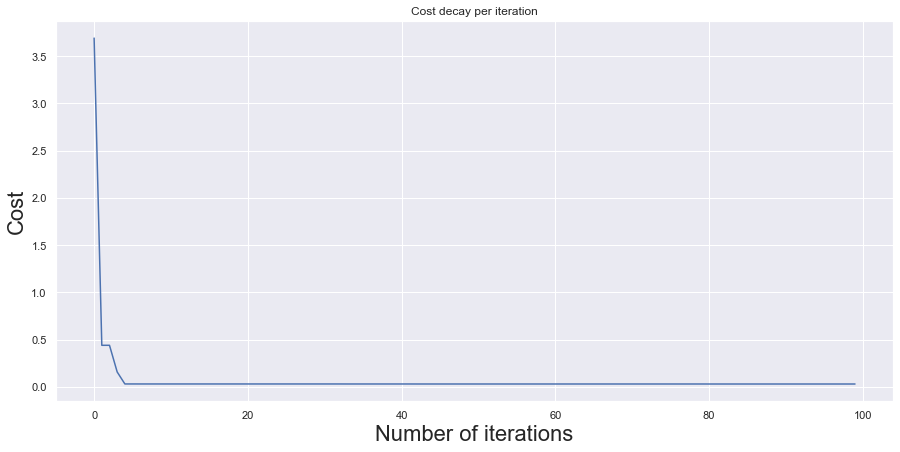

Accuracy of training: 1.0
Accuracy of test/validation: 1.0


In [27]:
eta=1
global Movie_W
_,_,_,Movie_W,Movie_b= full_model(optimization_parameters,eta,ntwk_settings,X_train,Y_train,X_test,Y_test)

Wow! Great! This simple heuristics could give a very good prediction model! Let's take a look at it more carefully.

<h3> 2.2 - Visualizing mass shuffle and dynamic behavior of weights </h3>

Let's create a video with the weights in order to see how they evolve through time, that is, iterations:

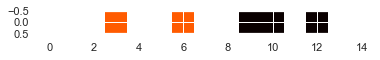

In [28]:
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Initialize the animation plot
fig = plt.gcf()

def updatefig(i):
    im = plt.imshow(Movie_W[:,:,i],cmap=plt.get_cmap('hot'),interpolation='nearest',vmin=-1,vmax=1)
    return im,

frames = np.shape(Movie_W)[-1]
ani = animation.FuncAnimation(fig, updatefig, interval=200, frames=frames,blit=True)

ani.save('NN_shallow_random.mp4')

In [29]:
import io
import base64
from IPython.display import HTML

video = io.open('NN_shallow_random.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<center><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video></center>'''.format(encoded.decode('ascii')))

>Remark: recall that we are visualizing what is happening in the first layer.

AS we did in the previous notebook, let's plot it


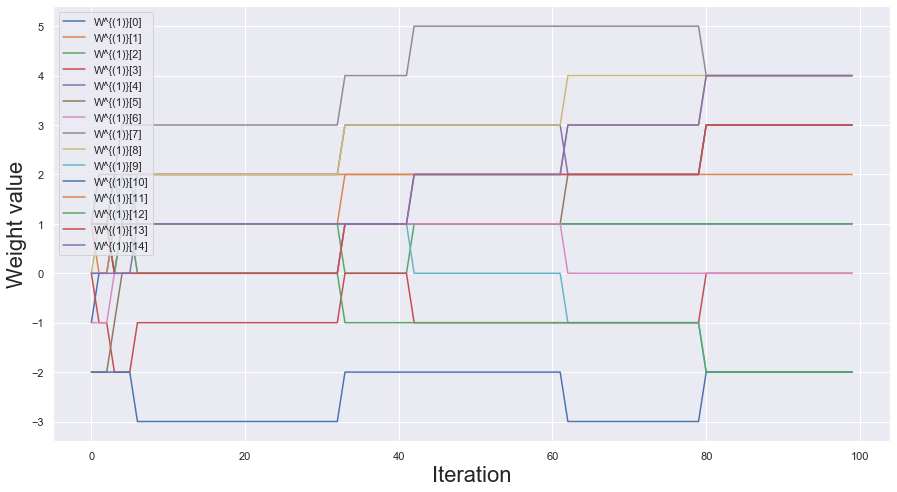

In [30]:
plt.figure(figsize=(15,8))

for i in range(k):
    plt.plot(Movie_W[0,i,:],label="W^{(1)}["+str(i)+"]")

plt.legend(loc=2)
plt.xlabel('Iteration',size=22)
plt.ylabel('Weight value',size=22)
plt.show()

Whaaaat?!! Why are the weights not getting separated??!! Yes, they are, but in AVERAGE!

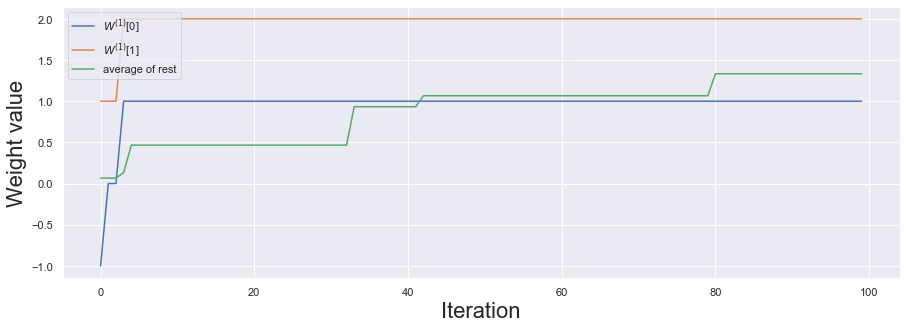

In [31]:
plt.figure(figsize=(15,5))

cop_Movie = np.copy(Movie_W)
v_0 = np.copy(Movie_W[0,0,:])
v_1 = np.copy(Movie_W[0,1,:])
cop_Movie[0,0,:]=0*Movie_W[0,0,:]
cop_Movie[0,1,:]=0*Movie_W[0,1,:]

plt.plot(v_0,label="$W^{(1)}$["+str(0)+"]")
plt.plot(v_1,label="$W^{(1)}$["+str(1)+"]")
plt.plot(np.squeeze(np.mean(cop_Movie,1)),label="average of rest")
plt.xlabel('Iteration',size=22)
plt.ylabel('Weight value',size=22)
plt.legend(loc=2)
plt.show()

The "best way" to avoid any issue with weights $W[i]$ for $i\geq 2$ is "shutting them off": curiously, the average doesn't seem to be converging to zero.

You can certainly do the same for larger NN, but the shallowest model is the best to see the effect of mass shuffling on the weights: as the video goes you start seeing less mass on the weights $W^{(i)}$ for $i\geq 2$. It is also possible to wonder what are the possible ways to shuffle mass in a NN, because backpropagation is one of them (indeed, a very effecient one!). We could also think of other methods, but let's not worry about that for these notes: I will  investigate that a bit further in future notebooks.

> __Remark (on backpropagation):__ An interesting point in using backpropagation methods is that they give an idea about "which way to go" for each weight. That's the magic of differentiation and gradient methods: they provide a very nice heuristics to search for better weights. This should be put in contrast to the current method we are playing with: even though state space is "smaller",  heuristics for discrite models are in general quite primitive. 

In [32]:
Movie_averaged= np.zeros([1,3,Movie_W.shape[-1]]) 
Movie_averaged[0,0,:] = Movie_W[0,0,:]
Movie_averaged[0,1,:] = Movie_W[0,1,:]
Movie_averaged[0,2,:] = np.mean(Movie_W[0,2:,:],0)

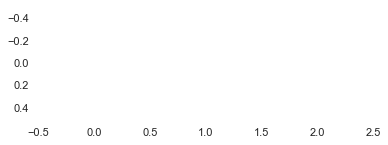

In [33]:
global Movie_averaged

fig = plt.gcf()

def updatefig(i):
    im = plt.imshow(Movie_averaged[:,:,i],cmap=plt.get_cmap('hot'),interpolation='nearest',vmin=-1,vmax=1)
    return im,

frames = np.shape(Movie_averaged)[-1]
ani = animation.FuncAnimation(fig, updatefig, interval=200, frames=frames,blit=True)
ani.save('NN_shallow_averaged_random.mp4')

In [34]:
video = io.open('NN_shallow_averaged_random.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<center><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video> </center>'''.format(encoded.decode('ascii')))

With regards to b, it doesn't take to long for it to find the right value:

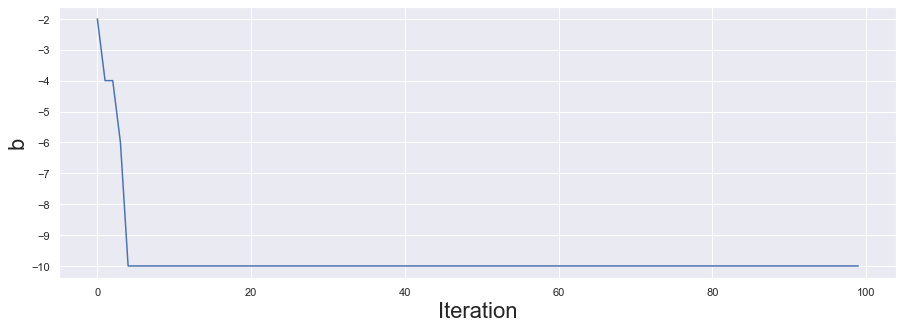

In [35]:
plt.figure(figsize=(15,5))
plt.plot(Movie_b[0,0,:])
plt.xlabel('Iteration',size=22)
plt.ylabel('b',size=22)
plt.show()

You should run the code a few times (because it has a random element in it). Sometimes you see  surprising things, like b "overshooting" (that is, getting lower than -10), going back, and "climb down" again to -10, the correct shift in the prediction boundary.

<h2><center> 3- Prediction boundaries:  non-linear case study</center></h2>

The boundary between classes in the previous model was linear, thus one could exepect a good performance of even a shallow NN (a logit model is the simplest possible NN you can imagine). But let's see what happens if we change the boundary a bit. By doing so we also bring in the second coordinate, making it "slightly" more relevant for the prediction, but not that much: on average, the model still "separates well" with a simple linear boundary.

In [44]:
N = 800
X = 10*np.random.randn(2,N)
Y = np.array((X[0,:]+ 2*X[1,:]>=1*np.sin(X[1,:]) +5),np.int32)

additional_dimension =13
Additional_dimension_coordinates = np.zeros([additional_dimension,N])
X = np.concatenate((X,Additional_dimension_coordinates),axis=0)
X[2:,:] = .1*np.random.randn(additional_dimension,N)

split_sample= StratifiedShuffleSplit(n_splits=1, test_size=.2)

for train_index, test_index in split_sample.split(np.transpose(X),np.transpose(Y)):
    X_train,Y_train = X[:,train_index],np.reshape(Y[train_index],(1,-1))
    X_test,Y_test = X[:,test_index],np.reshape(Y[test_index],(1,-1))  

<Figure size 432x288 with 0 Axes>

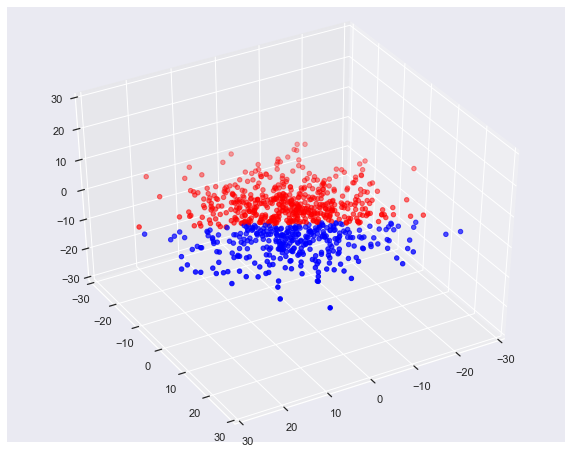

In [45]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
colors =['red','blue']
vec_color = [colors[i] for i in Y[:]]

ax.scatter3D(X[0,:1000],X[1,:1000],X[2,:1000],color=vec_color[:1000]);
ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(-30, 30)

ax.view_init(40, 60)  # This sets the angle by which we rotate the axis

In [46]:
optimization_parameters={
    'epochs':400,
    'printing':True
}

k = 2 + additional_dimension
nodes_per_layer = np.array([k,1],ndmin=1)

type_activation = ['sigmoid']
ntwk_settings={
    'number_nodes':nodes_per_layer,
    'activation_type':type_activation
}


 Cost at 0th iterate: 36.935165

 Cost at 20th iterate: 0.048725158

 Cost at 40th iterate: 0.047548015

 Cost at 60th iterate: 0.047548015

 Cost at 80th iterate: 0.047548015

 Cost at 100th iterate: 0.040229224

 Cost at 120th iterate: 0.03624066

 Cost at 140th iterate: 0.03624066

 Cost at 160th iterate: 0.034872226

 Cost at 180th iterate: 0.034872226

 Cost at 200th iterate: 0.034872226

 Cost at 220th iterate: 0.034328334

 Cost at 240th iterate: 0.032354303

 Cost at 260th iterate: 0.032354303

 Cost at 280th iterate: 0.032354303

 Cost at 300th iterate: 0.032354303

 Cost at 320th iterate: 0.032354303

 Cost at 340th iterate: 0.032354303

 Cost at 360th iterate: 0.032354303

 Cost at 380th iterate: 0.030880686


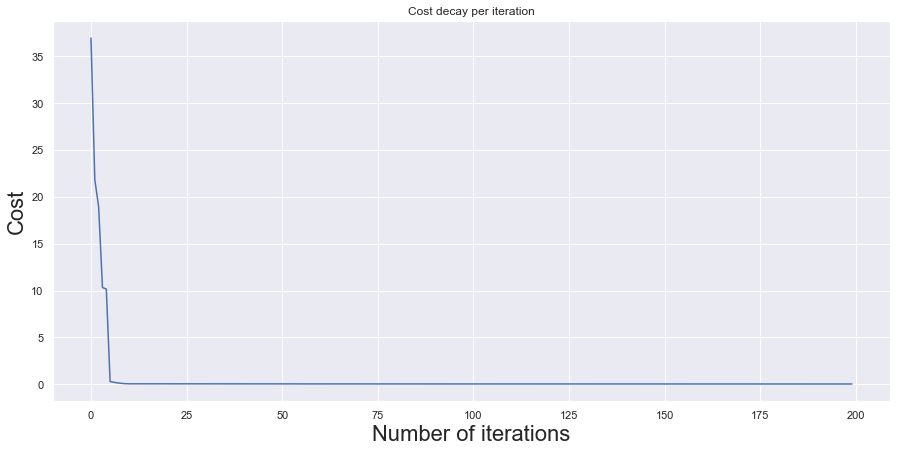

Accuracy of training: 0.9890625
Accuracy of test/validation: 0.99375


In [47]:
eta = 5
_,_,_,Movie_W,Movie_b= full_model(optimization_parameters,eta,ntwk_settings,X_train,Y_train,X_test,Y_test)

It is clear that the accuracy of the model has decayed, in both the training and in the test set. Nevertheless, the accuracy is really high!

As before, let's plot the dynamic behavior of the weights

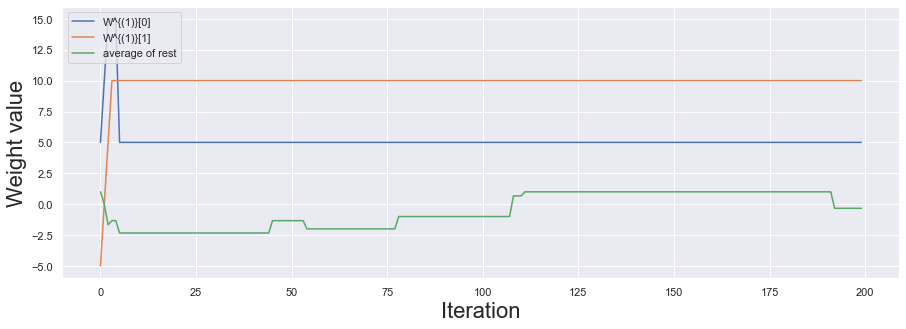

In [48]:
plt.figure(figsize=(15,5))

cop_Movie = np.copy(Movie_W)
v_0 = np.copy(Movie_W[0,0,:])
v_1 = np.copy(Movie_W[0,1,:])
cop_Movie[0,0,:]=0*Movie_W[0,0,:]
cop_Movie[0,1,:]=0*Movie_W[0,1,:]

plt.plot(v_0,label="W^{(1)}["+str(0)+"]")
plt.plot(v_1,label="W^{(1)}["+str(1)+"]")
plt.plot(np.squeeze(np.mean(cop_Movie,1)),label="average of rest")
plt.xlabel('Iteration',size=22)
plt.ylabel('Weight value',size=22)
plt.legend(loc=2)
plt.show()

How about b?

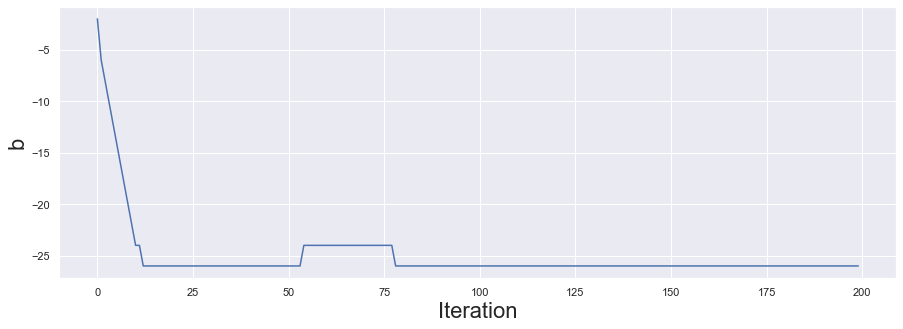

In [49]:
plt.figure(figsize=(15,5))
plt.plot(Movie_b[0,0,:])
plt.xlabel('Iteration',size=22)
plt.ylabel('b',size=22)
plt.show()

Notice that we are not at all using any information about the local structure of the model. This is a "silly" model in the sense that the mass shuffle uses no information about the model to do the shuffling. 

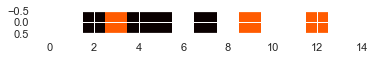

In [50]:
# Initialize the animation plot
fig = plt.gcf()

def updatefig(i):
    im = plt.imshow(Movie_W[:,:,i],cmap=plt.get_cmap('hot'),interpolation='nearest',vmin=-1,vmax=1)
    return im,

frames = np.shape(Movie_W)[-1]
ani = animation.FuncAnimation(fig, updatefig, interval=200, frames=frames,blit=True)
ani.save('NN_shallow_random_blnr_bdr.mp4')


In [51]:

video = io.open('NN_shallow_random_blnr_bdr.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<center><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video></center>'''.format(encoded.decode('ascii')))

And that's it for now. 